# Notebook 2 — Document Search via Embeddings

In this notebook we apply the same embedding and similarity-search ideas
from Notebook 1 to a **real document**.

We take a lecture PDF, extract its text page by page, convert each page
(or paragraph) into a vector embedding, and then **search inside the document**
using semantic similarity.

### Learning goals
- Decompose a PDF into searchable text units
- Build embeddings for document parts
- Retrieve relevant pages using semantic search

In [1]:
# ------------------------------------------------------------
# Proxy configuration (DWD)
# ------------------------------------------------------------
import os

PROXY = "http://ofsquid.dwd.de:8080"

os.environ["HTTP_PROXY"]  = PROXY
os.environ["HTTPS_PROXY"] = PROXY
os.environ["http_proxy"]  = PROXY
os.environ["https_proxy"] = PROXY
os.environ["NO_PROXY"]    = "localhost,127.0.0.1"

print("Proxy configured:", PROXY)


Proxy configured: http://ofsquid.dwd.de:8080


In [2]:
# ------------------------------------------------------------
# Install PyPDF2 (PDF text extraction)
# ------------------------------------------------------------
!pip install --upgrade PyPDF2
!pip install pymupdf

In [3]:
# ------------------------------------------------------------
# Imports
# ------------------------------------------------------------
import numpy as np
from sentence_transformers import SentenceTransformer
from PyPDF2 import PdfReader
from numpy.linalg import norm

In [4]:
# ------------------------------------------------------------
# Load sentence embedding model
# ------------------------------------------------------------
model = SentenceTransformer(
    "all-MiniLM-L6-v2",
    device="cpu"
)

print("Model loaded.")
print("Embedding dimension:", model.get_sentence_embedding_dimension())


Model loaded.
Embedding dimension: 384


In [5]:
# ------------------------------------------------------------
# Load lecture PDF and extract text per page
# ------------------------------------------------------------
pdf_path = "../../lectures/lec05/lec05.pdf"   # <-- adjust filename if needed

reader = PdfReader(pdf_path)

pages = []
page_ids = []

for i, page in enumerate(reader.pages):
    text = page.extract_text()
    if text and len(text.strip()) > 50:
        pages.append(text.strip())
        page_ids.append(i + 1)

print(f"Loaded {len(pages)} pages from PDF.")

Loaded 27 pages from PDF.


In [6]:
# ------------------------------------------------------------
# Inspect a sample page
# ------------------------------------------------------------
print("Page number:", page_ids[0])
print("-" * 60)
print(pages[4][:1000])

Page number: 1
------------------------------------------------------------
Model Capacity and Trainable Parameters
What defines model capacity?
▶Number of parameters
▶Network depth
▶Width of layers
Higher capacity:
▶Fits more complex functions
▶Risk of overfittingParameter counting
Each Layer(n in→nout) :n in·nout+nout
Total parameters=/summationdisplay
ℓ(nℓ−1nℓ+nℓ)
Example (1–16–16–1):
(1·16+16) + (16·16+16) + (16·1+1) =337
Roland Potthast Lecture 5 2025–2026 Slide 4


In [7]:
# ------------------------------------------------------------
# Embed all pages
# ------------------------------------------------------------
page_embeddings = model.encode(
    pages,
    convert_to_numpy=True,
    show_progress_bar=False
)

print("Embedding matrix shape:", page_embeddings.shape)

Embedding matrix shape: (27, 384)


In [8]:
# ------------------------------------------------------------
# Cosine similarity
# ------------------------------------------------------------
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

In [9]:
# ------------------------------------------------------------
# Search most relevant pages
# ------------------------------------------------------------
def search_pdf(query, model, pages, embeddings, page_ids, top_k=3):
    query_emb = model.encode(query, convert_to_numpy=True)

    scores = []
    for i, emb in enumerate(embeddings):
        score = cosine_similarity(query_emb, emb)
        scores.append((page_ids[i], score, pages[i]))

    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_k]

In [10]:
# ------------------------------------------------------------
# Example queries
# ------------------------------------------------------------
queries = [
    "What is gradient descent?",
    "Explain convolutional neural networks",
    "How does backpropagation work?"
]

for q in queries:
    print("-", q)


- What is gradient descent?
- Explain convolutional neural networks
- How does backpropagation work?


In [11]:
# ------------------------------------------------------------
# Function: semantic PDF search (text first, compact PDF view)
# ------------------------------------------------------------
import fitz  # PyMuPDF
from IPython.display import display, Markdown
from PIL import Image
import io

def search_and_show_pdf(
    query,
    model,
    pages,
    page_embeddings,
    page_ids,
    pdf_path,
    top_k=3,
    dpi=110,          # lower DPI → smaller PDF rendering
    max_width=600,    # limit image width
    text_chars=800
):
    """
    Perform semantic search on a PDF and display:
    1) query
    2) extracted text snippet
    3) corresponding PDF page (compact)
    """

    display(Markdown(f"### 🔍 Query: **{query}**"))

    results = search_pdf(
        query,
        model,
        pages,
        page_embeddings,
        page_ids,
        top_k=top_k
    )

    doc = fitz.open(str(pdf_path))

    for rank, (page_no, score, text) in enumerate(results, start=1):
        display(Markdown(
            f"#### Result {rank}: Page {page_no} "
            f"(similarity = {score:.3f})"
        ))

        # --- Show extracted text first ---
        display(Markdown("**Extracted text (snippet):**"))
        display(Markdown(f"> {text[:text_chars].replace('\n', ' ')}"))

        # --- Render PDF page (smaller) ---
        page = doc.load_page(page_no - 1)
        pix = page.get_pixmap(dpi=dpi)
        img = Image.open(io.BytesIO(pix.tobytes("png")))

        # Resize for compact display
        if img.width > max_width:
            scale = max_width / img.width
            img = img.resize(
                (int(img.width * scale), int(img.height * scale)),
                Image.LANCZOS
            )

        display(img)

    doc.close()

### 🔍 Query: **What is a graph network**

#### Result 1: Page 9 (similarity = 0.623)

**Extracted text (snippet):**

> Why Graph Neural Networks? When FFNNs are not enough ▶Data points are not independent ▶Relations between entities matter ▶Ordering is not fixed or meaningful Typical examples ▶Physical grids and meshes ▶Sensor networks ▶Molecules, social networks Graph structure with nodes and edges Core idea ▶Nodes exchange information ▶Learning respects graph structure ▶Inductive bias for relational data Roland Potthast Lecture 5 2025–2026 Slide 8

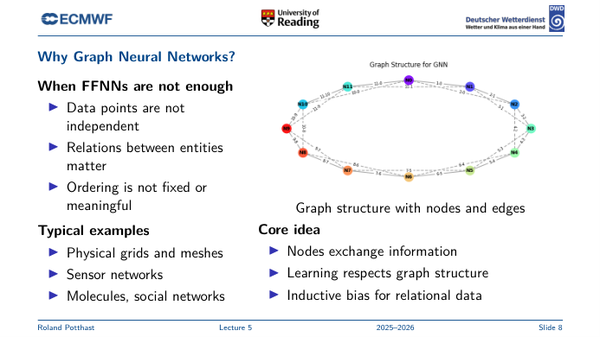

#### Result 2: Page 10 (similarity = 0.588)

**Extracted text (snippet):**

> Basic Graph Concepts Graph definition ▶GraphG= (V,E) ▶NodesV: entities ▶EdgesE: relations Node data ▶Each node has featuresx i ▶Labelsy ifor supervision ▶Features may be physical states Ikosahedral graph Key distinction ▶Data lives on nodes ▶Structure lives in edges ▶Learning uses both Roland Potthast Lecture 5 2025–2026 Slide 9

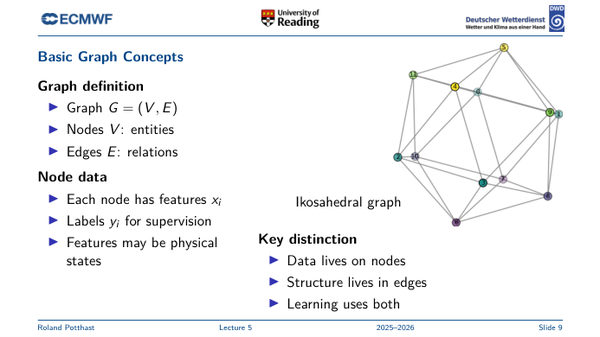

#### Result 3: Page 27 (similarity = 0.488)

**Extracted text (snippet):**

> Neural Network Architectures — Chapter Summary Architectures covered ▶FFNN : global function approximation ▶GNN : interactions on graphs ▶CNN : local pattern extraction ▶LSTM : temporal dependencies Inductive bias / framework: ▶Structure encoded in connectivityTasks demonstrated ▶FFNN:regression , classification ▶GNN:transport and dynamics ▶CNN: function classification ▶LSTM:anomaly detection Core message: ▶Architecture must match data structure ▶No universally optimal network Roland Potthast Lecture 5 2025–2026 Slide 26

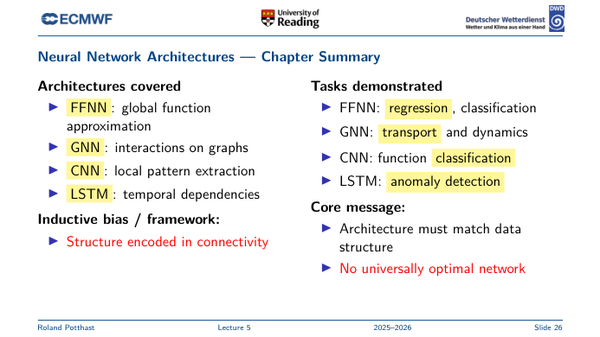

In [12]:
# ------------------------------------------------------------
# Single-query semantic search
# ------------------------------------------------------------
search_and_show_pdf(
    query="What is a graph network",
    model=model,
    pages=pages,
    page_embeddings=page_embeddings,
    page_ids=page_ids,
    pdf_path=pdf_path,
    top_k=3
)

### 🔍 Query: **Convolutional Networks?**

#### Result 1: Page 15 (similarity = 0.496)

**Extracted text (snippet):**

> Why Convolutional Neural Networks? Key idea ▶Exploitlocal structure ▶Same operation everywhere ▶Strong inductive bias Typical data ▶Images (2D grids) ▶Time series (1D signals) ▶Physical fields on grids CNNs assume: locality+translation invarianceConvolution instead of full connectivity ▶Small kernel slides over input ▶Shared weights across positions ▶Far fewer parameters than FFNNs Mathematically (1D): yi=K/summationdisplay k=−Kwkxi+k Interpretation: ▶Learn local patterns ▶Detect edges, waves, peaks ▶Build hierarchy via depth Roland Potthast Lecture 5 2025–2026 Slide 14

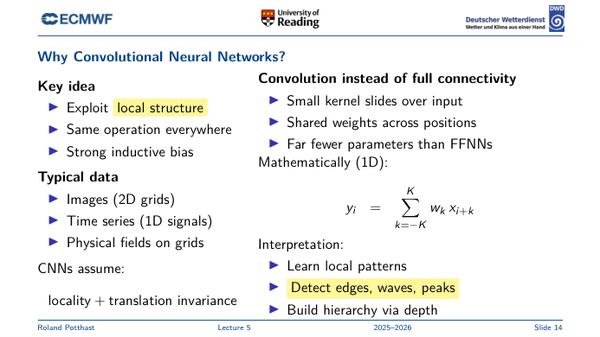

#### Result 2: Page 17 (similarity = 0.489)

**Extracted text (snippet):**

> CNN Structure for Function Classification Network structure ▶1D convolutions for local patterns ▶Nonlinear feature extraction ▶Fully connected classifier I n p u t : (B, 1 , 50) Conv1 : (B, 16 , 50) Conv2 : (B, 32 , 50) F l a t t e n : (B, 1600) FC : (B, 4)CNN model definition 1classFunctionClassifierCNN (nn. Module ): 2def__init__ ( self ): 3super(). __init__ () 4self . conv1 = nn. Conv1d (1, 16,5, padding =2) 5self . conv2 = nn. Conv1d (16 ,32 ,5 , padding =2) 6self .fc1 = nn. Linear (32*50 , 128) 7self .fc2 = nn. Linear (128 , 4) 8 9defforward (self , x): 10x = torch . relu ( self . conv1 (x)) 11x = torch . relu ( self . conv2 (x)) 12x = x. view (x. size (0) , -1) 13x = torch . relu ( self . fc1(x)) 14returnself .fc2(x) Roland Potthast Lecture 5 2025–2026 Slide 16

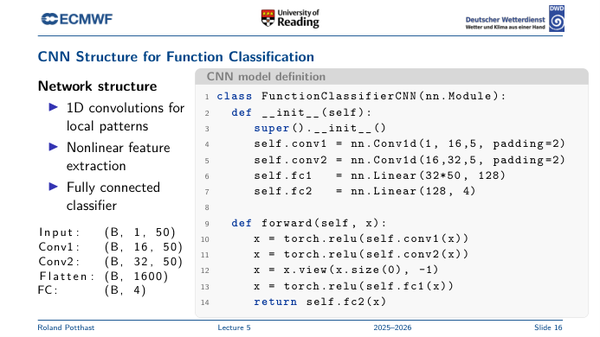

#### Result 3: Page 4 (similarity = 0.424)

**Extracted text (snippet):**

> FFNN as a Mathematical Mapping Layer-wise computation ▶Affine transformation ▶Nonlinear activation ▶Composition of functions Each layer increases expressiveness . Purelydata-driven mapping.x(0)=x x(1)=σ/parenleftig W1x(0)+b1/parenrightig x(2)=σ/parenleftig W2x(1)+b2/parenrightig ˆy=W 3x(2)+b3 σ: ReLU, tanh, sigmoid Roland Potthast Lecture 5 2025–2026 Slide 3

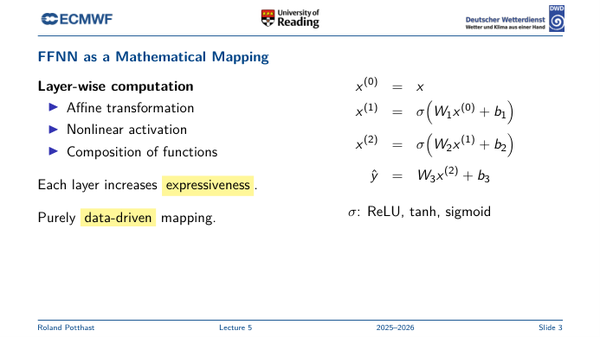

In [13]:
# ------------------------------------------------------------
# Single-query semantic search
# ------------------------------------------------------------
search_and_show_pdf(
    query="Convolutional Networks?",
    model=model,
    pages=pages,
    page_embeddings=page_embeddings,
    page_ids=page_ids,
    pdf_path=pdf_path,
    top_k=3
)

### 🔍 Query: **temporal pattern**

#### Result 1: Page 21 (similarity = 0.385)

**Extracted text (snippet):**

> Why LSTMs for Time Series and Anomalies? Problem setting ▶Sequential sensor data ▶Temporal correlations ▶Deviations over time Why not FFNN / CNN? ▶No explicit memory ▶Limited temporal context Key idea: anomaly = temporal inconsistency σσ Tanh σ· + · ·Tanhct−1Cell ht−1Hidden xt InputctCell htHidden ytOutputft it ˜ctotLSTM provides: ▶Explicit memory state ▶Controlled information flow ▶Long-term dependency modeling Roland Potthast Lecture 5 2025–2026 Slide 20

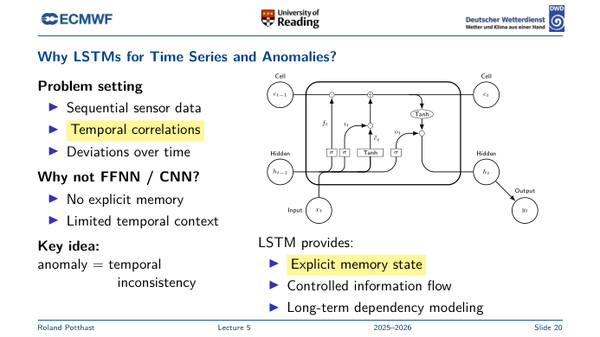

#### Result 2: Page 23 (similarity = 0.346)

**Extracted text (snippet):**

> From LSTM States to Reconstruction Error What goes in ▶Input sequencex 1:T ▶One value per time step What the LSTM does ▶Updates(h t,ct)sequentially ▶Encodes temporal structure What comes out ▶Hidden statesh t ▶Latent temporal representationReconstruction step ˆxt=W yht+by Training objective L=1 TT/summationdisplay t=1∥xt−ˆxt∥2 Anomaly detection ▶Low error: normal sequence ▶High error: anomalous sequence Wy,bylearned jointly with LSTM weights Roland Potthast Lecture 5 2025–2026 Slide 22

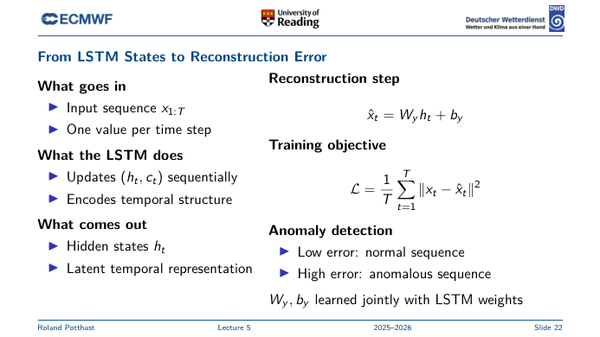

#### Result 3: Page 26 (similarity = 0.331)

**Extracted text (snippet):**

> Detected Anomalies in Sensor Data What is shown? ▶Unseen test sequences ▶Reconstruction vs. input Color coding ▶Blue: normal ▶Red: anomaly Interpretation: ▶Model flags temporal inconsistency Original (solid) vs. reconstructed (dashed) Roland Potthast Lecture 5 2025–2026 Slide 25

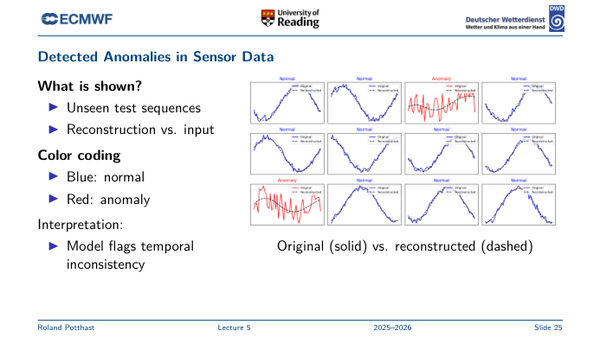

In [14]:
# ------------------------------------------------------------
# Single-query semantic search
# ------------------------------------------------------------
search_and_show_pdf(
    query="temporal pattern",
    model=model,
    pages=pages,
    page_embeddings=page_embeddings,
    page_ids=page_ids,
    pdf_path=pdf_path,
    top_k=3
)

### What we observe

- Queries retrieve **specific lecture pages**, not the whole document
- Keyword overlap is not required
- The same embedding logic as in Notebook 1 applies

This is the core mechanism behind document-level RAG systems:
**retrieve first, generate later**.